In [1]:
from absl import app
from absl import flags
from jax import config
from nerf import utils
from nerf import datasets

import jax
from jax import jit
from jax import device_put
import jax.numpy as jnp
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


FLAGS = flags.FLAGS
utils.define_flags()
flags.DEFINE_string("voxel_dir", "data/voxel", "voxel data directory.")
flags.DEFINE_string("vh_save", "shape", "Save type ('shape' of 'color')")
flags.DEFINE_bool("vh_test", False, "If True, test the result of visual hull")
config.parse_flags_with_absl()

# FLAGS.config = "configs/blender"
# FLAGS.data_dir = "data/nerf_synthetic/lego"

FLAGS.config = "configs/llff"
FLAGS.data_dir = "data/nerf_llff_data/fern"
FLAGS.vh_test = True

if FLAGS.config is not None:
    utils.update_flags(FLAGS)


# larger size requires larger images
t_n, t_f = FLAGS.near, FLAGS.far
vsize = 400               # voxel size
rsize = (t_f - t_n) / 2.  # real size
# t_c = (t_f + t_n) / 2.  # center


@jit
def digitize(p):
    p = jnp.round((p+rsize) * (vsize/(rsize*2)))
    return jnp.clip(p.astype(jnp.int16), 0, vsize-1)
    # requires more memory
    # return jnp.digitize(p, jnp.linspace(t_n-t_c, t_f-t_c, vsize)).astype(jnp.int16)


@jit
def carve_voxel(o, d, mask):
    voxel_si = jnp.zeros([vsize, vsize, vsize]).astype(jnp.uint8)
    mask = device_put(mask)

    t_all = jnp.linspace(t_n, t_f, vsize+1)
    ray_p = digitize(o[:,:,None] + d[:,:,None] * t_all[None, None, :, None])

    mask = jnp.repeat(mask[:,:,None].astype(jnp.uint8), vsize+1, axis=2)
    voxel_si = voxel_si.at[ray_p[:,:,:,1], ray_p[:,:,:,0], ray_p[:,:,:,2]].set(mask)
    return voxel_si


@jit
def paint_voxel(o, d, img, voxel_c, voxel_t, voxel_s):
    voxel_ci = jnp.zeros([vsize, vsize, vsize, 3]).astype(jnp.float32)
    voxel_ti = jnp.zeros([vsize, vsize, vsize]).astype(jnp.int16) + (vsize+1)

    t_all = jnp.linspace(t_n, t_f, vsize+1)    
    ray_p = digitize(o[:,:,None] + d[:,:,None] * t_all[None, None, :, None])

    ti = jnp.argmax(voxel_s[ray_p[:,:,:,1], ray_p[:,:,:,0], ray_p[:,:,:,2]], axis=2)
    ray_p_ti = jnp.sum((ray_p * jnp.eye(vsize+1)[ti][:,:,:,None]),axis=2).astype(jnp.int16)
    voxel_ci = voxel_ci.at[ray_p_ti[:,:,1], ray_p_ti[:,:,0], ray_p_ti[:,:,2]].set(img)
    voxel_ti = voxel_ti.at[ray_p_ti[:,:,1], ray_p_ti[:,:,0], ray_p_ti[:,:,2]].set(ti)
    voxel_c = jnp.where((voxel_t > voxel_ti)[...,None], voxel_ci, voxel_c)
    voxel_t = jnp.minimum(voxel_t, voxel_ti)
    return voxel_t, voxel_c


@jit
def render_voxel(voxel_s, voxel_c, o, d):
    t_all = jnp.linspace(t_n, t_f, vsize+1)
    ray_p = digitize(o[:,:,None] + d[:,:,None] * t_all[None, None, :, None])

    ti = jnp.argmax(voxel_s[ray_p[:,:,:,1], ray_p[:,:,:,0], ray_p[:,:,:,2]], axis=2)
    ray_p_ti = jnp.sum((ray_p * jnp.eye(vsize+1)[ti][:,:,:,None]),axis=2).astype(jnp.int16)
    img = voxel_c[ray_p_ti[:,:,1], ray_p_ti[:,:,0], ray_p_ti[:,:,2]]
    return img


class PureDataset(datasets.dataset_dict[FLAGS.dataset]):
    def start(self):
        pass

In [2]:
target = FLAGS.data_dir.split("/")[-1]
os.makedirs(os.path.join(FLAGS.voxel_dir, target), exist_ok=True)
# 4032x3024
dataset = PureDataset("train", FLAGS)

if FLAGS.dataset == "blender":
    dataset.images = dataset.images.reshape(-1,800,800,3)
    dataset.rays = dataset.rays._replace(origins = dataset.rays.origins.reshape(-1,800,800,3))
    dataset.rays = dataset.rays._replace(directions = dataset.rays.directions.reshape(-1,800,800,3))
    dataset.rays = dataset.rays._replace(viewdirs = dataset.rays.viewdirs.reshape(-1,800,800,3))
elif FLAGS.dataset == "llff":
    dataset.images = dataset.images.reshape(-1,756,1008,3)
    dataset.rays = dataset.rays._replace(origins = dataset.rays.origins.reshape(-1,756,1008,3))
    dataset.rays = dataset.rays._replace(directions = dataset.rays.directions.reshape(-1,756,1008,3))
    dataset.rays = dataset.rays._replace(viewdirs = dataset.rays.viewdirs.reshape(-1,756,1008,3))

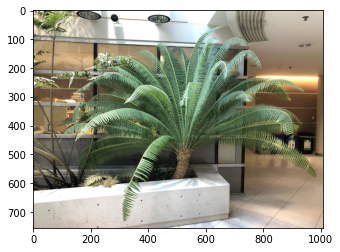

In [3]:
plt.imshow(dataset.images[0]); plt.show()

In [6]:
dataset.rays.origins[0].shape

(756, 1008, 3)

In [7]:
dataset.camtoworlds.shape

(17, 3, 4)

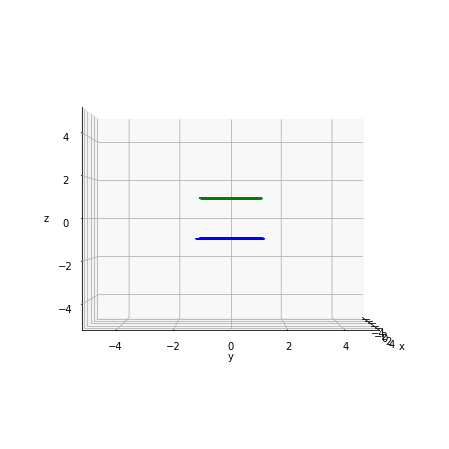

In [9]:
# fern

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5)
# ax.view_init(elev=90, azim=90)
ax.view_init(elev=0, azim=0)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for idx in range(0, len(dataset.rays.origins), 2):
    # (512, 512, 3) (512, 512, 3)
    # o, d = camera_params_to_rays(f, cx, cy, data['pose'], width, height)

    # # focal point（red）
    # o_x, o_y, o_z = o[0, :1].T
    # ax.scatter(o_x, o_y, o_z, c='red')
    o = dataset.rays.origins[idx]
    d = dataset.rays.directions[idx]

    # render lower limit（blue）
    x_n, y_n, z_n = (o + d * t_n)[::16, ::16].reshape(-1, 3).T
    ax.scatter(x_n, y_n, z_n, c='blue', s=0.1)

    # render upper limit (green)
    x_f, y_f, z_f = (o + d * t_f)[::16, ::16].reshape(-1, 3).T
    ax.scatter(x_f, y_f, z_f, c='green', s=0.1)

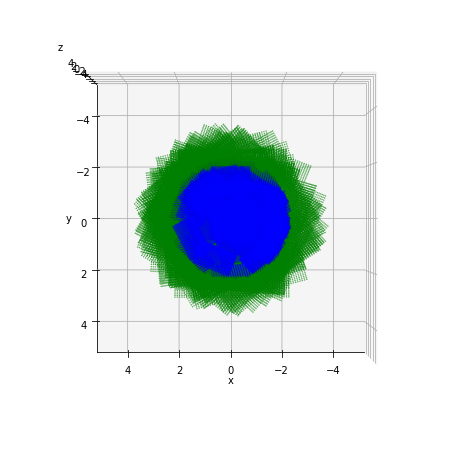

In [ ]:
# lego

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5)
ax.view_init(elev=90, azim=90)
# ax.view_init(elev=0, azim=0)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for idx in range(0, len(dataset.rays.origins), 2):
    # (512, 512, 3) (512, 512, 3)
    # o, d = camera_params_to_rays(f, cx, cy, data['pose'], width, height)

    # # focal point（red）
    # o_x, o_y, o_z = o[0, :1].T
    # ax.scatter(o_x, o_y, o_z, c='red')
    o = dataset.rays.origins[idx]
    d = dataset.rays.directions[idx]

    # render lower limit（blue）
    x_n, y_n, z_n = (o + d * t_n)[::16, ::16].reshape(-1, 3).T
    ax.scatter(x_n, y_n, z_n, c='blue', s=0.1)

    # render upper limit (green)
    x_f, y_f, z_f = (o + d * t_f)[::16, ::16].reshape(-1, 3).T
    ax.scatter(x_f, y_f, z_f, c='green', s=0.1)

100%|██████████| 17/17 [00:02<00:00,  8.13it/s]


uint8 (400, 400, 400)
done!


100%|██████████| 17/17 [00:04<00:00,  3.51it/s]


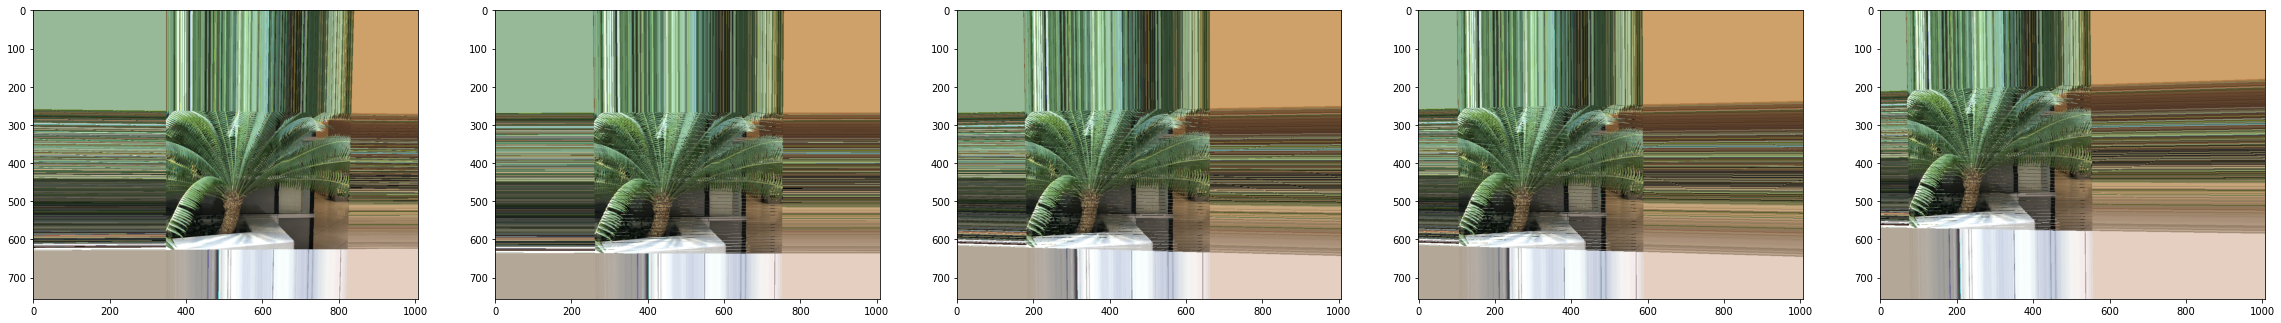

In [10]:
# shape 
voxel_s = np.zeros([vsize, vsize, vsize]).astype(np.bool)

for idx in tqdm(range(dataset.size)):
    o = dataset.rays.origins[idx]
    d = dataset.rays.directions[idx]
    img = dataset.images[idx]
    mask = np.sum(img != 1., axis=2) != 0
    # remove whiteout
    mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((3,3)))
    # dilation (It makes appearance worse, but recommended for voxel initialization)
    mask = cv2.dilate(mask.astype(np.uint8), np.ones((3,3)), iterations=1)
    voxel_s += carve_voxel(o, d, mask).block_until_ready()

voxel_s = (voxel_s == 100).astype(jnp.uint8)

if FLAGS.vh_save == "shape":
    print(voxel_s.dtype, voxel_s.shape)
    np.save(os.path.join(FLAGS.voxel_dir, target, "voxel.npy"), voxel_s)
    print("done!")


if FLAGS.vh_save == "color" or FLAGS.vh_test:
    # color
    voxel_c = device_put(jnp.ones([vsize, vsize, vsize, 3]).astype(jnp.float32))  # white
    voxel_t = device_put(jnp.zeros([vsize, vsize, vsize]).astype(jnp.int16) + (vsize+1))

    for idx in tqdm(range(dataset.size)):
        o = dataset.rays.origins[idx]
        d = dataset.rays.directions[idx]
        img = dataset.images[idx]
        output = paint_voxel(o, d, img, voxel_c, voxel_t, voxel_s)
        jax.tree_map(lambda x: x.block_until_ready(), output)
        voxel_t, voxel_c = output

    if FLAGS.vh_save == "color":
        print(voxel_c.dtype, voxel_c.shape)
        np.save(os.path.join(FLAGS.voxel_dir, target, "voxel.npy"), voxel_c)
        print("done!")


if FLAGS.vh_test:
    # test
    N = 5
    plt.figure(figsize=(40,8))
    for i in range(N):
        o = dataset.rays.origins[i]
        d = dataset.rays.directions[i]
        frame = render_voxel(voxel_s, voxel_c, o, d)
        plt.subplot(1,N,i+1); plt.imshow(frame)
    # plt.savefig(os.path.join(FLAGS.voxel_dir, target, "voxel.png"))
    plt.show()
    # plt.close()

In [11]:
FLAGS.near, FLAGS.far

(0.0, 1.0)